<a href="https://colab.research.google.com/github/joiinar35/DSci_Demos/blob/main/Improved_K_Means_Algortihm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Improved K-Means Algortihm for Optimal Location of Geomagnetic Field Interpolation Points at the Earth's Surface**




### Author: Ramon Caraballo ###

##**Objective**



Given a set of *N* observation points, find the optimal number of clusters in which all the points can be distributed. Additionally, the clusters must have an approximate radius *r*, predefined.

### **Data Ingestion**
We load some pakages

In [82]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


We load the input data (i.e. the observation pts data) into a pandas dataframe.

In [62]:
file_path ='/content/drive/MyDrive/Colab Notebooks/nodos400-230v5.csv'

df=pd.read_csv(file_path, index_col='nodo', usecols=['nodo','Subestacion', 'Lat', 'Long'])

df.head()

,Subestacion,Lat,Long
nodo,,,
1,Bacum 2,27.5160,-110.0727
2,Los Mochis (Choacahui),25.9759,-109.0179
3,Culiacan (La Higuera),24.6988,-107.5069
4,Mazatlan,23.1898,-106.3522
5,Tepic,21.5808,-104.9357


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 1 to 246
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Subestacion  246 non-null    object 
 1   Lat          246 non-null    float64
 2   Long         246 non-null    float64
dtypes: float64(2), object(1)
memory usage: 7.7+ KB


Install geodatasets package (if not installed) and create a geodataframe with the dataframe data

In [64]:
!pip install geodatasets
from geodatasets import get_path

In [65]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326")

gdf.head()

,Subestacion,Lat,Long,geometry
nodo,,,,
1,Bacum 2,27.5160,-110.0727,POINT (-110.07270 27.51600)
2,Los Mochis (Choacahui),25.9759,-109.0179,POINT (-109.01790 25.97590)
3,Culiacan (La Higuera),24.6988,-107.5069,POINT (-107.50690 24.69880)
4,Mazatlan,23.1898,-106.3522,POINT (-106.35220 23.18980)
5,Tepic,21.5808,-104.9357,POINT (-104.93570 21.58080)


I want to plot the input data in a map

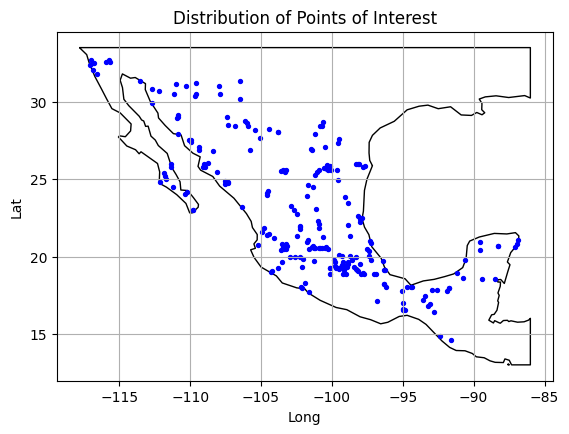

In [66]:
world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to Mexican area.
ax = world.clip([-120, 13, -86, 33.5]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="blue", markersize=8)
plt.title("Distribution of Points of Interest")
plt.xlabel('Long')
plt.ylabel('Lat')
plt.grid(True)
plt.show()


Now we start to fine tune the K-Means Algorithm

Define a mean cluster radius of *r=150 km*  corresponds to a separation of near 2.5 degrees in latitude and longitude.
We start with k=5 clusters and will find the optimal value for k.



In [67]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import RobustScaler, StandardScaler

Clustering algorithms like K-means require feature scaling of the data as part of data preprocessing to produce good results. This is because clustering techniques use distance calculation between the data points. Hence it is proper to bring data of different units under a common scale.

We choose Robist scaler because our points not neccesarily are Normal distributed and some of them behaves like outliers.
Robust-Scaler is calculated by using the interquartile range(IQR), here, IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). It can handle outlier data points as well.

In [68]:
scaler=RobustScaler()
scale = scaler.fit_transform(gdf[['Lat','Long']])
gdf_scale = pd.DataFrame(scale, columns = ['Lat','Long']);

gdf_scale.head()

,Lat,Long
0,0.900409,-1.269699
1,0.657939,-1.121113
2,0.456876,-0.908264
3,0.219303,-0.745606
4,-0.034014,-0.546069


### **Finding the optimum value of K** ###

In [70]:
from scipy.stats import iqr
from scipy.spatial import distance

gdata = gdf[['Lat','Long']].values

iqrange = iqr(gdata, axis=0)

medians = np.median(gdata, axis=0)

print(f'iqr = {iqrange}, medians = {medians}')

iqr = [6.351725 7.098925], medians = [  21.79685 -101.0592 ]


In [ ]:
K=range(5,41)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k, random_state=20)
    kmeans=kmeans.fit(gdf_scale)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

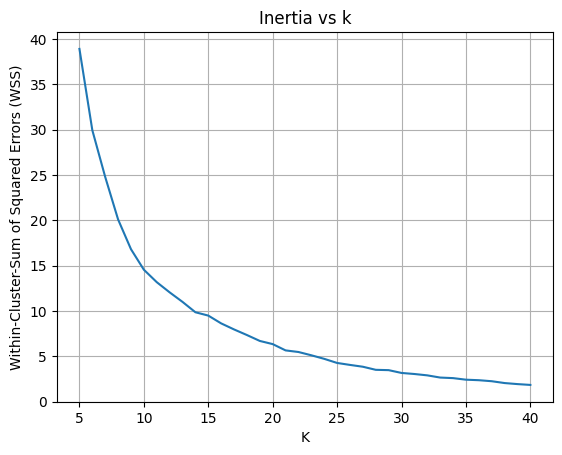

In [73]:
plt.xlabel('K')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)')
plt.title('Inertia vs k')
plt.grid(True)
plt.plot(K,wss)

According to the elbow method, k=9 o 10 seem to be the optimum values of k.
Let try the Silhouette score

In [ ]:
from sklearn.metrics import silhouette_score
ssc=[]
K=range(5,40)
for i in K:
    clusterer=cluster.KMeans(n_clusters=i, random_state=20)
    preds=clusterer.fit_predict(gdf_scale)
    centers = clusterer.cluster_centers_


    # Without sampling
    #score = silhouette_score(gdf_scale, preds)

    # With sampling
    score = silhouette_score(gdf_scale, preds, sample_size=15, random_state=10)

    print(i, score)
    ssc.append(score)



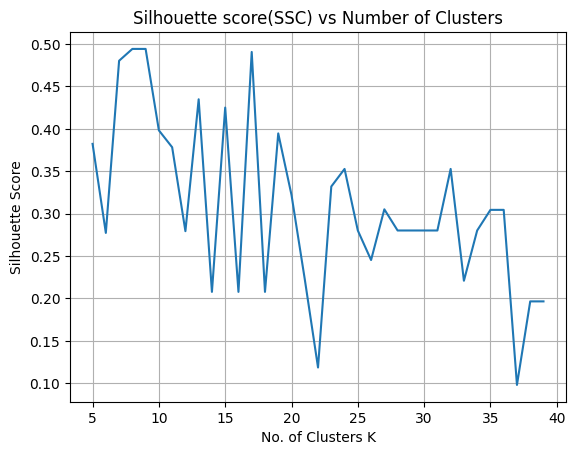

In [42]:
plt.xlabel('No. of Clusters K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette score(SSC) vs Number of Clusters')
plt.grid(True)
plt.plot(K,ssc)

According to the avg silhouette score, the values of k=9 & k=17 sounds good.
We will chose k=17 as the number of clusters in order to fit into the required distance between centroids.
Chosing k=9 will be nice but the distance between centroids maybe large. This might outfit twice the validity range of the magnetic observations *r=300 km*  

[[-0.42958208  0.55764758]
 [ 0.44591108 -1.40641013]
 [ 0.39987017 -0.28403325]
 [-0.76059977  1.02824351]
 [ 1.34828122 -1.42281023]
 [-0.55462256 -0.12973514]
 [ 0.70779985  0.144399  ]
 [-0.16522058  1.82978409]
 [-0.12332807 -0.0369226 ]
 [ 1.11252652 -0.70284409]
 [ 1.67226576 -2.17441999]
 [-0.20467975 -0.3882983 ]
 [ 0.86832092 -1.21757671]
 [-0.51747754  1.45625218]
 [ 0.52677344 -0.97769169]
 [ 0.06785401  0.40058037]
 [-0.3724149   0.25991264]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


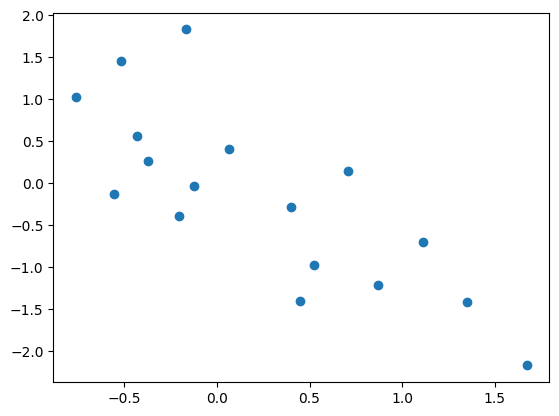

In [74]:
k=17
clusterer=cluster.KMeans(n_clusters=k,random_state=20)
preds=clusterer.fit_predict(gdf_scale)
centers = clusterer.cluster_centers_

print(centers)

plt.scatter(centers[:,0], centers[:,1])

Hence we start to fine tuning the optimum value of k.
 First, we calculate the matrix distance between centers.

In [75]:
dmtx = np.zeros((k,k))


for i in range(k-1):
  for j in range(i+1,k):
    dmtx[i,j]= distance.euclidean(centers[j], centers[i])

#print(dmtx)

In [76]:
Dmax=np.sqrt(sum(4/np.power(iqrange,2)))
print(Dmax)

0.4225159090622885


In [77]:
pm=np.empty(k-1)
for j in range(k-1):
  pm[j] = np.min(dmtx[j,j+1:k])

mdist = np.median(pm)


print(mdist)

0.5177147020806698


As the median distance between centroids is of the order of the maximum distance allowed Dmax=*2r*,  for k >= 17 it is enough to consider k=17 as the optimum number of centroids. Next we convert their coordinates to geographical ones and plot into a map.

In [78]:
# Geographical Coordinates of the centroids
centroids = np.add(np.multiply(centers, iqrange), medians)

dfk = pd.DataFrame({'Lat': centroids[:,0], 'Lon': centroids[:,1]})



print(dfk)

          Lat         Lon
0   19.068263  -97.100502
1   24.629155 -111.043200
2   24.336715 -103.075531
3   16.965729  -93.759776
4   30.360762 -111.159623
5   18.274040 -101.980180
6   26.292600 -100.034122
7   20.747414  -88.069700
8   21.013504 -101.321311
9   28.863312 -106.048637
10  32.418622 -116.495244
11  20.496780 -103.815701
12  27.312186 -109.702686
13  18.509975  -90.721375
14  25.142770 -107.999760
15  22.227840  -98.215510
16  19.431373  -99.214100


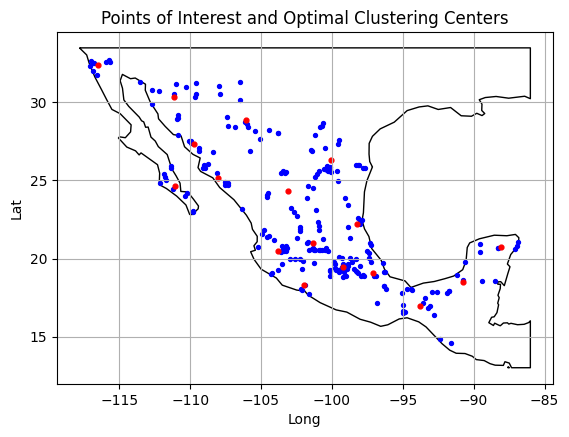

In [87]:
cgdf = gpd.GeoDataFrame(dfk, geometry=gpd.points_from_xy(dfk.Lon, dfk.Lat), crs="EPSG:4326")



world = gpd.read_file(get_path("naturalearth.land"))

# We restrict to Mexican area.
ax = world.clip([-120, 13, -86, 33.5]).plot(color="white", edgecolor="black")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="blue", markersize=8)
cgdf.plot(ax=ax, color='red', markersize=12)

plt.title("Points of Interest and Optimal Clustering Centers")
plt.xlabel('Long')
plt.ylabel('Lat')
plt.grid(True)
plt.show()
